# Streaming Ad Conversion Modeling & Cold-Start Budget Optimization

## Executive Summary
This notebook builds a predictive model to estimate **purchase conversion rates** for streaming TV ad impressions across `(company_id, network_id)` pairs — including **unseen combinations**.

Using predicted marginal conversion rates, we then optimize a **$100,000** cold-start TV advertising budget for a new advertiser (`company_id = 1`) under:
- **Diminishing returns** (concave response curve)
- **Diversification constraints** (max share per network, HHI cap)

### Deliverables
- Regularized **Poisson GLM** with exposure offset (`log(impressions)`)
- Holdout evaluation and calibration
- Predictions for all company/network pairs
- Convex optimization for budget allocation using `cvxpy`

> **Note on scale:** if the impression table is extremely large, we fit the model on an aggregated `(company_id, network_id)` table, which is far smaller and sufficient for the fixed-effects GLM used here.


In [1]:
# If running in Colab, uncomment:
# !pip install -q pandas numpy matplotlib pyarrow gdown cvxpy scs scikit-learn

import os
import json
import tarfile
import pathlib
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cvxpy as cp
from sklearn.model_selection import train_test_split

np.random.seed(7)

plt.rcParams["figure.figsize"] = (8, 4)


## 1) Data Ingestion

This section downloads (optional), safely extracts the tarball, and loads parquet tables.

In [2]:
import gdown

# ---- Configuration ----
GDRIVE_URL = "https://drive.google.com/file/d/131XvlX7tOPgvbx-n5BnDv_xWVDsQrGS3/view"  # replace if needed
TARBALL_NAME = "hw_data.tar.gz"
EXTRACT_DIR = pathlib.Path("hw_data")  # extracted contents
DOWNLOAD_DATA = True  # set False if tarball is already present locally

# -----------------------

def safe_extract_tar(tar_path: str, extract_dir: pathlib.Path) -> None:
    """Safely extract a tar file into extract_dir (blocks path traversal)."""
    extract_dir.mkdir(exist_ok=True)
    with tarfile.open(tar_path, "r:*") as t:
        for member in t.getmembers():
            member_path = extract_dir / member.name
            if not str(member_path.resolve()).startswith(str(extract_dir.resolve())):
                raise RuntimeError(f"Blocked suspicious path: {member.name}")
        t.extractall(extract_dir)

if DOWNLOAD_DATA:
    gdown.download(GDRIVE_URL, TARBALL_NAME, quiet=False, fuzzy=True)

if not os.path.exists(TARBALL_NAME):
    raise FileNotFoundError(f"Tarball not found: {TARBALL_NAME}. Set DOWNLOAD_DATA=True or place it in the working directory.")

safe_extract_tar(TARBALL_NAME, EXTRACT_DIR)

events_df = pd.read_parquet(EXTRACT_DIR / "events")
impressions_df = pd.read_parquet(EXTRACT_DIR / "impressions")

print("events:", events_df.shape)
print("impressions:", impressions_df.shape)
events_df.head()


Downloading...
From (original): https://drive.google.com/uc?id=131XvlX7tOPgvbx-n5BnDv_xWVDsQrGS3
From (redirected): https://drive.google.com/uc?id=131XvlX7tOPgvbx-n5BnDv_xWVDsQrGS3&confirm=t&uuid=dd40b85d-c40f-41ef-82ef-96e474dcef44
To: /kaggle/working/hw_data.tar.gz
100%|██████████| 568M/568M [00:06<00:00, 91.1MB/s]
/tmp/ipykernel_17/642569483.py:19: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  t.extractall(extract_dir)


events: (21195735, 2)
impressions: (163700000, 5)


,user_id,company_id
0,9609182,6
1,8662568,6
2,8313867,6
3,88796,6
4,432138,6


## 2) Quick Data Checks

In [3]:
# Basic integrity checks
assert set(["user_id", "company_id"]).issubset(events_df.columns)
assert set(["user_id", "company_id", "network_id", "lift", "conv"]).issubset(impressions_df.columns)

print("Missing values (events):")
print(events_df.isna().sum())

print("\nMissing values (impressions):")
print(impressions_df.isna().sum())

print("\nConversion rate overall:", impressions_df["conv"].mean())
print("Lift rate overall:", impressions_df["lift"].mean())


Missing values (events):
user_id       0
company_id    0
dtype: int64

Missing values (impressions):
company_id    0
network_id    0
user_id       0
lift          0
conv          0
dtype: int64

Conversion rate overall: 0.00020163714111178985
Lift rate overall: 0.0019952596212583994


## 3) Feature Construction: Aggregate to (company, network)

We aggregate impression-level rows to a much smaller table for modeling conversions via a GLM with exposure offset.

In [4]:
agg = (
    impressions_df
    .groupby(["company_id", "network_id"], as_index=False)
    .agg(
        impressions=("conv", "size"),
        conversions=("conv", "sum"),
        lifts=("lift", "sum"),
    )
)

print("Aggregated rows:", agg.shape)
agg.head()


Aggregated rows: (1637, 5)


,company_id,network_id,impressions,conversions,lifts
0,0,0,100000,11,176
1,0,1,100000,9,153
2,0,2,100000,20,255
3,0,3,100000,34,265
4,0,4,100000,21,237


## 4) Model: Regularized Poisson GLM via IRLS

We model conversions with an exposure offset:

\[
Y_{c,n} \sim \text{Poisson}(\mu_{c,n}), \quad \log(\mu_{c,n}) = \log(\text{impressions}_{c,n}) + \beta_0 + \beta_c + \gamma_n
\]

Ridge regularization stabilizes estimates for sparse pairs and supports generalization to unseen combinations.

In [5]:
def build_design_matrix(df: pd.DataFrame):
    company_dummies = pd.get_dummies(df["company_id"].astype("category"), drop_first=True)
    network_dummies = pd.get_dummies(df["network_id"].astype("category"), drop_first=True)

    X = pd.concat([company_dummies, network_dummies], axis=1)
    X.insert(0, "intercept", 1.0)

    columns = list(X.columns)
    design = {
        "company_cols": company_dummies.columns.to_numpy(),
        "network_cols": network_dummies.columns.to_numpy(),
    }
    return X.to_numpy(dtype=float), columns, design

def fit_poisson_ridge_irls(df_agg: pd.DataFrame, lambda_: float = 10.0, max_iter: int = 50, tol: float = 1e-8):
    """Fit regularized Poisson GLM with exposure offset using IRLS (no explicit diag(W))."""
    X, columns, design = build_design_matrix(df_agg)
    y = df_agg["conversions"].to_numpy(dtype=float)
    impressions = df_agg["impressions"].to_numpy(dtype=float)
    offset = np.log(np.clip(impressions, 1.0, None))

    n, p = X.shape

    # penalty matrix (intercept not penalized)
    P = np.eye(p)
    P[0, 0] = 0.0

    beta = np.zeros(p, dtype=float)

    for _ in range(max_iter):
        eta = X @ beta + offset
        mu = np.exp(eta)

        # working response
        z = eta + (y - mu) / np.clip(mu, 1e-12, None)

        # weighted least squares without forming diag(W)
        w = mu
        WX = X * w[:, None]
        LHS = X.T @ WX + lambda_ * P
        RHS = X.T @ (w * (z - offset))

        beta_new = np.linalg.solve(LHS, RHS)

        if np.linalg.norm(beta_new - beta) < tol:
            beta = beta_new
            break
        beta = beta_new

    # diagnostics
    eta_hat = X @ beta + offset
    mu_hat = np.exp(eta_hat)

    pearson_phi = float(np.sum(((y - mu_hat) ** 2) / np.clip(mu_hat, 1e-12, None)) / max(n - p, 1))

    return {
        "beta": beta,
        "columns": columns,
        "design": design,
        "pearson_phi": pearson_phi,
    }

def predict_theta(fit, company_ids, network_ids):
    """Predict theta (conversion rate per impression) for all cartesian pairs."""
    beta = fit["beta"]
    comp_cols = list(fit["design"]["company_cols"])
    net_cols = list(fit["design"]["network_cols"])

    rows = []
    for c in company_ids:
        for n in network_ids:
            x = [1.0]
            for cname in comp_cols:
                x.append(1.0 if cname == c else 0.0)
            for nname in net_cols:
                x.append(1.0 if nname == n else 0.0)
            x = np.asarray(x, dtype=float)
            theta = float(np.exp(x @ beta))
            rows.append((c, n, theta))
    return pd.DataFrame(rows, columns=["company_id", "network_id", "theta_hat"])


## 5) Holdout Evaluation & Calibration

We hold out a subset of `(company_id, network_id)` pairs, train on the remainder, and evaluate generalization. This aligns with the requirement to predict for unseen company/network combinations.

In [6]:
# Train/test split over aggregated (company, network) rows
train_df, test_df = train_test_split(agg, test_size=0.2, random_state=7)

fit = fit_poisson_ridge_irls(train_df, lambda_=10.0)
print("Pearson dispersion (train fit):", round(fit["pearson_phi"], 3))

# Predict expected conversions on test
X_test, cols_test, design_test = build_design_matrix(test_df)

# Important: the dummy columns must match the training design.
# We'll rebuild X_test manually using training dummy sets.
def build_design_matrix_from_training(df, fit_design):
    comp_cols = list(fit_design["company_cols"])
    net_cols = list(fit_design["network_cols"])

    # Build matrix with same columns as training (intercept + comp + net)
    X_list = []
    for _, row in df.iterrows():
        x = [1.0]
        for cname in comp_cols:
            x.append(1.0 if cname == row["company_id"] else 0.0)
        for nname in net_cols:
            x.append(1.0 if nname == row["network_id"] else 0.0)
        X_list.append(x)
    return np.asarray(X_list, dtype=float)

X_test = build_design_matrix_from_training(test_df, fit["design"])
impr_test = test_df["impressions"].to_numpy(dtype=float)
y_test = test_df["conversions"].to_numpy(dtype=float)

offset_test = np.log(np.clip(impr_test, 1.0, None))
mu_test = np.exp(X_test @ fit["beta"] + offset_test)  # expected conversions
rate_pred = mu_test / impr_test
rate_actual = y_test / impr_test

# Metrics
# Poisson deviance for each row: 2*(y*log(y/mu) - (y-mu)); define 0*log(0) = 0
with np.errstate(divide="ignore", invalid="ignore"):
    term = np.where(y_test > 0, y_test * np.log(y_test / np.clip(mu_test, 1e-12, None)), 0.0)
poisson_deviance = float(2.0 * np.sum(term - (y_test - mu_test)))

# Weighted MAE on conversion rate, weighted by impressions
w = impr_test / impr_test.sum()
weighted_mae = float(np.sum(w * np.abs(rate_actual - rate_pred)))

# Baselines: global rate, network-only rate
global_rate = train_df["conversions"].sum() / train_df["impressions"].sum()
baseline_global = np.full_like(rate_pred, global_rate, dtype=float)

# Network-only: mean conversion rate per network on train; fallback to global
net_rate = (train_df.groupby("network_id")
            .apply(lambda d: d["conversions"].sum() / d["impressions"].sum())
            .to_dict())
baseline_net = np.array([net_rate.get(int(n), global_rate) for n in test_df["network_id"].to_numpy()])

weighted_mae_global = float(np.sum(w * np.abs(rate_actual - baseline_global)))
weighted_mae_net = float(np.sum(w * np.abs(rate_actual - baseline_net)))

results = pd.DataFrame({
    "Model": ["Poisson GLM (ridge)", "Baseline: global", "Baseline: network-only"],
    "Weighted MAE (rate)": [weighted_mae, weighted_mae_global, weighted_mae_net],
})
results


Pearson dispersion (train fit): 1.627


/tmp/ipykernel_17/3175500189.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d["conversions"].sum() / d["impressions"].sum())


,Model,Weighted MAE (rate)
0,Poisson GLM (ridge),0.000048
1,Baseline: global,0.000046
2,Baseline: network-only,0.000049


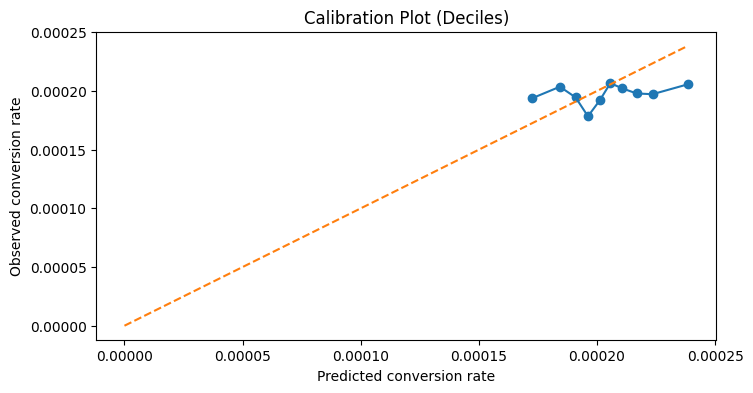

,decile,pred,actual,impressions
0,0,0.000173,0.000194,3300000
1,1,0.000184,0.000204,3300000
2,2,0.000191,0.000195,3300000
3,3,0.000196,0.000178,3200000
4,4,0.000201,0.000192,3300000
5,5,0.000206,0.000207,3300000
6,6,0.000211,0.000202,3200000
7,7,0.000217,0.000198,3300000
8,8,0.000224,0.000197,3300000
9,9,0.000239,0.000206,3300000


In [7]:
# Calibration by decile (predicted conversion rate)
eval_df = test_df.copy()
eval_df["pred_rate"] = rate_pred
eval_df["actual_rate"] = rate_actual

# deciles (handle duplicates by rank-based jitter if necessary)
eval_df = eval_df.sort_values("pred_rate").reset_index(drop=True)
eval_df["decile"] = pd.qcut(eval_df["pred_rate"].rank(method="first"), 10, labels=False)

calib = eval_df.groupby("decile").agg(
    pred=("pred_rate", "mean"),
    actual=("actual_rate", "mean"),
    impressions=("impressions", "sum")
).reset_index()

plt.plot(calib["pred"], calib["actual"], marker="o")
m = max(calib["pred"].max(), calib["actual"].max())
plt.plot([0, m], [0, m], "--")
plt.xlabel("Predicted conversion rate")
plt.ylabel("Observed conversion rate")
plt.title("Calibration Plot (Deciles)")
plt.show()

calib


## 6) Predict Conversion Rates for All Company/Network Pairs

We generate `theta_hat` for all pairs to support allocation decisions and unseen combinations.

In [8]:
# Ensure cold-start company_id=1 is included even if it never appeared in impressions
cold_start_company = 1

companies_in_data = np.sort(agg["company_id"].unique())
networks = np.sort(agg["network_id"].unique())

if cold_start_company not in companies_in_data:
    companies = np.sort(np.append(companies_in_data, cold_start_company))
else:
    companies = companies_in_data

preds_all = predict_theta(fit, companies, networks)

print("Included company_ids:", companies[:10], "... total =", len(companies))
print("Cold-start present in preds_all?:", (preds_all["company_id"] == cold_start_company).any())

preds_all.head()


Included company_ids: [0 1 2 3 4 5 6 7 8 9] ... total = 20
Cold-start present in preds_all?: True


,company_id,network_id,theta_hat
0,0,0,0.000193
1,0,1,0.000199
2,0,2,0.000210
3,0,3,0.000196
4,0,4,0.000208


## 7) Budget Allocation for Cold-Start Advertiser (company_id = 1)

We allocate 10,000,000 impressions ($100,000 at $0.01/impression) across networks.

We maximize a concave utility:

\[
U_i(x_i) = a_i (1 - e^{-b_i x_i})
\]

Constraints:
- \(\sum_i x_i = N\)
- \(x_i \le \text{max_share} \cdot N\)
- HHI cap: \(\sum_i (x_i/N)^2 \le \text{hhi_max}\)

This yields a realistic recommendation that avoids concentrating the entire budget in a single network.

In [9]:
def derive_diminishing_params(theta: np.ndarray, total_impressions: int, half_sat_share: float = 0.04, gamma: float = 1.0):
    theta = np.asarray(theta, dtype=float)
    N = float(total_impressions)
    b_base = np.log(2.0) / (half_sat_share * N)
    scale = (theta / np.clip(theta.mean(), 1e-12, None)) ** gamma
    b = b_base * scale
    a = theta / np.clip(b, 1e-12, None)
    return a, b

def optimize_allocation(preds_df: pd.DataFrame,
                        company_id: int = 1,
                        total_impressions: int = 10_000_000,
                        half_sat_share: float = 0.04,
                        max_share: float = 0.30,
                        hhi_max: float = 0.18,
                        tau_log: float = 0.0,
                        eps: float = 1.0,
                        gamma: float = 1.0):
    dfc = preds_df[preds_df["company_id"] == company_id].copy()
    if dfc.empty:
        raise ValueError(f"No predicted rows for company_id={company_id}")

    networks = dfc["network_id"].to_numpy()
    theta = dfc["theta_hat"].to_numpy(dtype=float)

    a, b = derive_diminishing_params(theta, total_impressions, half_sat_share=half_sat_share, gamma=gamma)

    k = len(networks)
    N = float(total_impressions)

    x = cp.Variable(k, nonneg=True)

    concave_terms = cp.multiply(a, (1 - cp.exp(-cp.multiply(b, x))))
    objective = cp.sum(concave_terms)

    if tau_log and tau_log > 0:
        objective += tau_log * cp.sum(cp.log(x + eps))

    constraints = [
        cp.sum(x) == N,
        x <= max_share * N,
        cp.sum_squares(x / N) <= hhi_max
    ]

    prob = cp.Problem(cp.Maximize(objective), constraints)
    prob.solve(solver=cp.SCS, verbose=False)

    if x.value is None:
        raise RuntimeError(f"Optimization failed: {prob.status}")

    alloc = np.maximum(0, np.array(x.value).ravel())
    share = alloc / N
    exp_conversions = float(np.sum(a * (1 - np.exp(-b * alloc))))
    hhi = float(np.sum(share ** 2))

    out = pd.DataFrame({
        "network_id": networks,
        "theta_hat": theta,
        "allocation_impressions": alloc,
        "allocation_share": share,
    }).sort_values("allocation_impressions", ascending=False)

    info = {
        "status": prob.status,
        "expected_conversions": exp_conversions,
        "hhi": hhi,
        "max_share_used": float(share.max()),
    }
    return out, info

allocation_df, alloc_info = optimize_allocation(preds_all, company_id=1)
alloc_info, allocation_df.head(10)


/usr/local/lib/python3.12/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


({'status': 'optimal_inaccurate',
  'expected_conversions': 1664.270705562067,
  'hhi': 0.025612303964051772,
  'max_share_used': 0.06011692249416127},
     network_id  theta_hat  allocation_impressions  allocation_share
 55          55   0.000231           601169.224942          0.060117
 22          22   0.000223           472137.475842          0.047214
 53          53   0.000221           438544.731417          0.043854
 63          63   0.000219           407733.678360          0.040773
 92          92   0.000217           383150.664067          0.038315
 95          95   0.000214           329122.306946          0.032912
 56          56   0.000211           297769.652859          0.029777
 62          62   0.000211           290607.013702          0.029061
 83          83   0.000211           288173.570733          0.028817
 49          49   0.000211           284083.986011          0.028408)

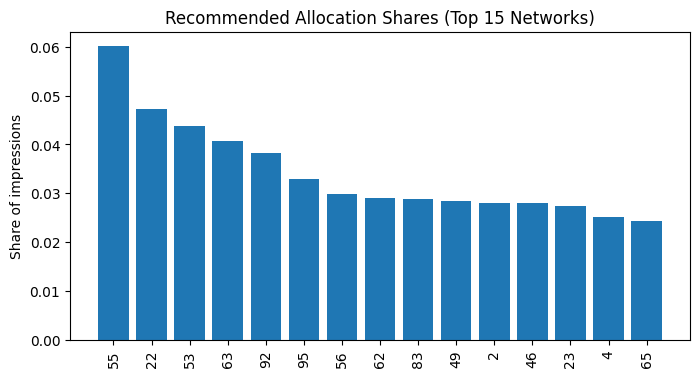

,network_id,theta_hat,allocation_impressions,allocation_share
55,55,0.000231,601169.224942,0.060117
22,22,0.000223,472137.475842,0.047214
53,53,0.000221,438544.731417,0.043854
63,63,0.000219,407733.678360,0.040773
92,92,0.000217,383150.664067,0.038315
95,95,0.000214,329122.306946,0.032912
56,56,0.000211,297769.652859,0.029777
62,62,0.000211,290607.013702,0.029061
83,83,0.000211,288173.570733,0.028817
49,49,0.000211,284083.986011,0.028408


In [10]:
# Visualize recommended allocation (top 15)
topk = 15
top_alloc = allocation_df.head(topk).copy()

plt.bar(top_alloc["network_id"].astype(str), top_alloc["allocation_share"])
plt.xticks(rotation=90)
plt.ylabel("Share of impressions")
plt.title(f"Recommended Allocation Shares (Top {topk} Networks)")
plt.show()

top_alloc


## 8) Sensitivity Check (Risk Tolerance)

We vary diversification constraints to see how recommendations change.

- **Conservative:** lower max share + lower HHI cap
- **Moderate:** default
- **Aggressive:** higher max share + higher HHI cap

This is helpful for communicating tradeoffs to stakeholders.

In [11]:
scenarios = [
    ("Conservative", {"max_share": 0.20, "hhi_max": 0.12}),
    ("Moderate",     {"max_share": 0.30, "hhi_max": 0.18}),
    ("Aggressive",   {"max_share": 0.45, "hhi_max": 0.28}),
]

summary_rows = []
for name, params in scenarios:
    alloc_df_s, info_s = optimize_allocation(preds_all, company_id=1, **params)
    summary_rows.append({
        "Scenario": name,
        "Expected conversions": info_s["expected_conversions"],
        "HHI": info_s["hhi"],
        "Max network share": info_s["max_share_used"],
        "Top network": int(alloc_df_s.iloc[0]["network_id"]),
        "Top share": float(alloc_df_s.iloc[0]["allocation_share"]),
    })

pd.DataFrame(summary_rows)


/usr/local/lib/python3.12/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


,Scenario,Expected conversions,HHI,Max network share,Top network,Top share
0,Conservative,1797.719048,0.010186,0.014795,55,0.014795
1,Moderate,1664.270706,0.025612,0.060117,55,0.060117
2,Aggressive,1803.539490,0.011300,0.019719,55,0.019719


## 9) Recommendations, Limitations, and Next Steps

### Recommendation (example wording)
- Start with the **Moderate** diversification setting for a balanced approach.
- Review the top recommended networks with business stakeholders for brand-fit and inventory constraints.
- If leadership is risk-averse, use the **Conservative** setting; if performance-seeking, consider the **Aggressive** setting.

### Limitations
- No timestamp → cannot model sequential exposure/frequency effects.
- Repeated exposure per user treated uniformly.
- Overdispersion (if present) suggests a Negative Binomial or hierarchical model.

### Next Steps
- Add a Negative Binomial GLM or quasi-Poisson uncertainty adjustment.
- Joint modeling of `lift` and `conv` (two-stage or hierarchical).
- Incorporate frequency-capping / saturation estimated from user-level exposure counts.
